In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sn
import itertools
from matplotlib import pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_curve, confusion_matrix


In [2]:
# Label Encoders to convert each qualitative variable into a quantitave variable

le = LabelEncoder()
le_gender = LabelEncoder()
le_rvsp = LabelEncoder()
le_rv_function = LabelEncoder()
le_size = LabelEncoder()
le_intervention = LabelEncoder()
le_sloe = LabelEncoder()

In [3]:
# Function to parse data from csv into a list

all_cols = []
def get_data(filename):
    with open(filename, "rt", encoding='utf8') as f:
        reader = csv.reader(f)
        i = next(reader, None)
        file = csv.reader(f)
        temp = list(file)
    return temp, i

In [4]:
# Establishing feature columns and associated headers

col_names = ['Sex (M/F)',
            'BMI',
            'DM (1/0)',
            'HTN (1/0)',
            'COPD (1/0)',
            'CTEPH (1/0)',
            'ESRD (1/0)',
            'Hx of Malignancy (1/0)',
            'Original EDA  (cm2)',
            'Original ESA (cm2)',
            'Original FAC (%)',
            'Original EndoGLS (%)',
            'Size/Location of Embolus',
            'RVSP',
            'RV Size',
            'RV Function',
            'McConnell\'s Sign',
            'TR Velocity',
            'Intervention']

In [5]:
# Function to remove 'N/A' From feature columns and replace with mean

def clean_and_mean(lists):
    lists = lists.replace('N/A', np.NaN)
    num_lists = lists.apply(pd.to_numeric, errors ='coerce')
    cleaned_lists = num_lists.apply(lambda x: x.fillna(x.mean()))
    return(np.array(cleaned_lists))

scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
# Function to seperate features and labels. The label_column defines the expected output in terms of suprevised learning. 

def seperate_features_and_labels(file, col_ind, label_column, columns):
    features = []
    labels = []
    for row in file:
        filt_row = list(row[i] for i in col_ind)
        features.append(filt_row)
        labels.append(int(row[label_column]))
        
    labels = np.asarray(labels, dtype=np.float32)
    
    df_features = pd.DataFrame(features, columns=columns)
    df_features['Sex (M/F)'] = le_gender.fit_transform(df_features['Sex (M/F)'])
    df_features['RVSP'] = le_rvsp.fit_transform(df_features['RVSP'])
    df_features['RV Size'] = le_size.fit_transform(df_features['RV Size'])
    df_features['RV Function'] = le_rv_function.fit_transform(df_features['RV Function'])
    df_features['Intervention'] = le_intervention.fit_transform(df_features['Intervention'])
    df_features['Size/Location of Embolus'] = le_sloe.fit_transform(df_features['Size/Location of Embolus'])


    cleaned_features = scaler.fit_transform(clean_and_mean((df_features)))
    return(cleaned_features, labels)

In [7]:
data, cols = get_data('scar_data_2.csv')

included_cols = []
for x in col_names:
    included_cols.append(cols.index(x))

label_column = cols.index('Death within 1 year')

f, l = seperate_features_and_labels(data, included_cols, label_column, col_names)
d_f = pd.DataFrame(data=f, columns=col_names)

In [8]:
# Establishing Random Forest Classifier and MinMaxScalar to normalize all features

model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
train, test, train_labels, test_labels = train_test_split(f, l, stratify = l, test_size = 0.3)
model.fit(train, train_labels)

y_preds = model.predict(test)

prec_temp = precision_score(test_labels, y_preds)
recall_temp = recall_score(test_labels, y_preds)

print("F1 Score: {}".format(f1_score(test_labels, y_preds)))
print("Prec Score: {}".format(prec_temp))
print("Recall Score: {}".format(recall_temp))
print("Accuracy Score: {}".format(accuracy_score(test_labels, y_preds)))

F1 Score: 0.8000000000000002
Prec Score: 0.8
Recall Score: 0.8
Accuracy Score: 0.8571428571428571


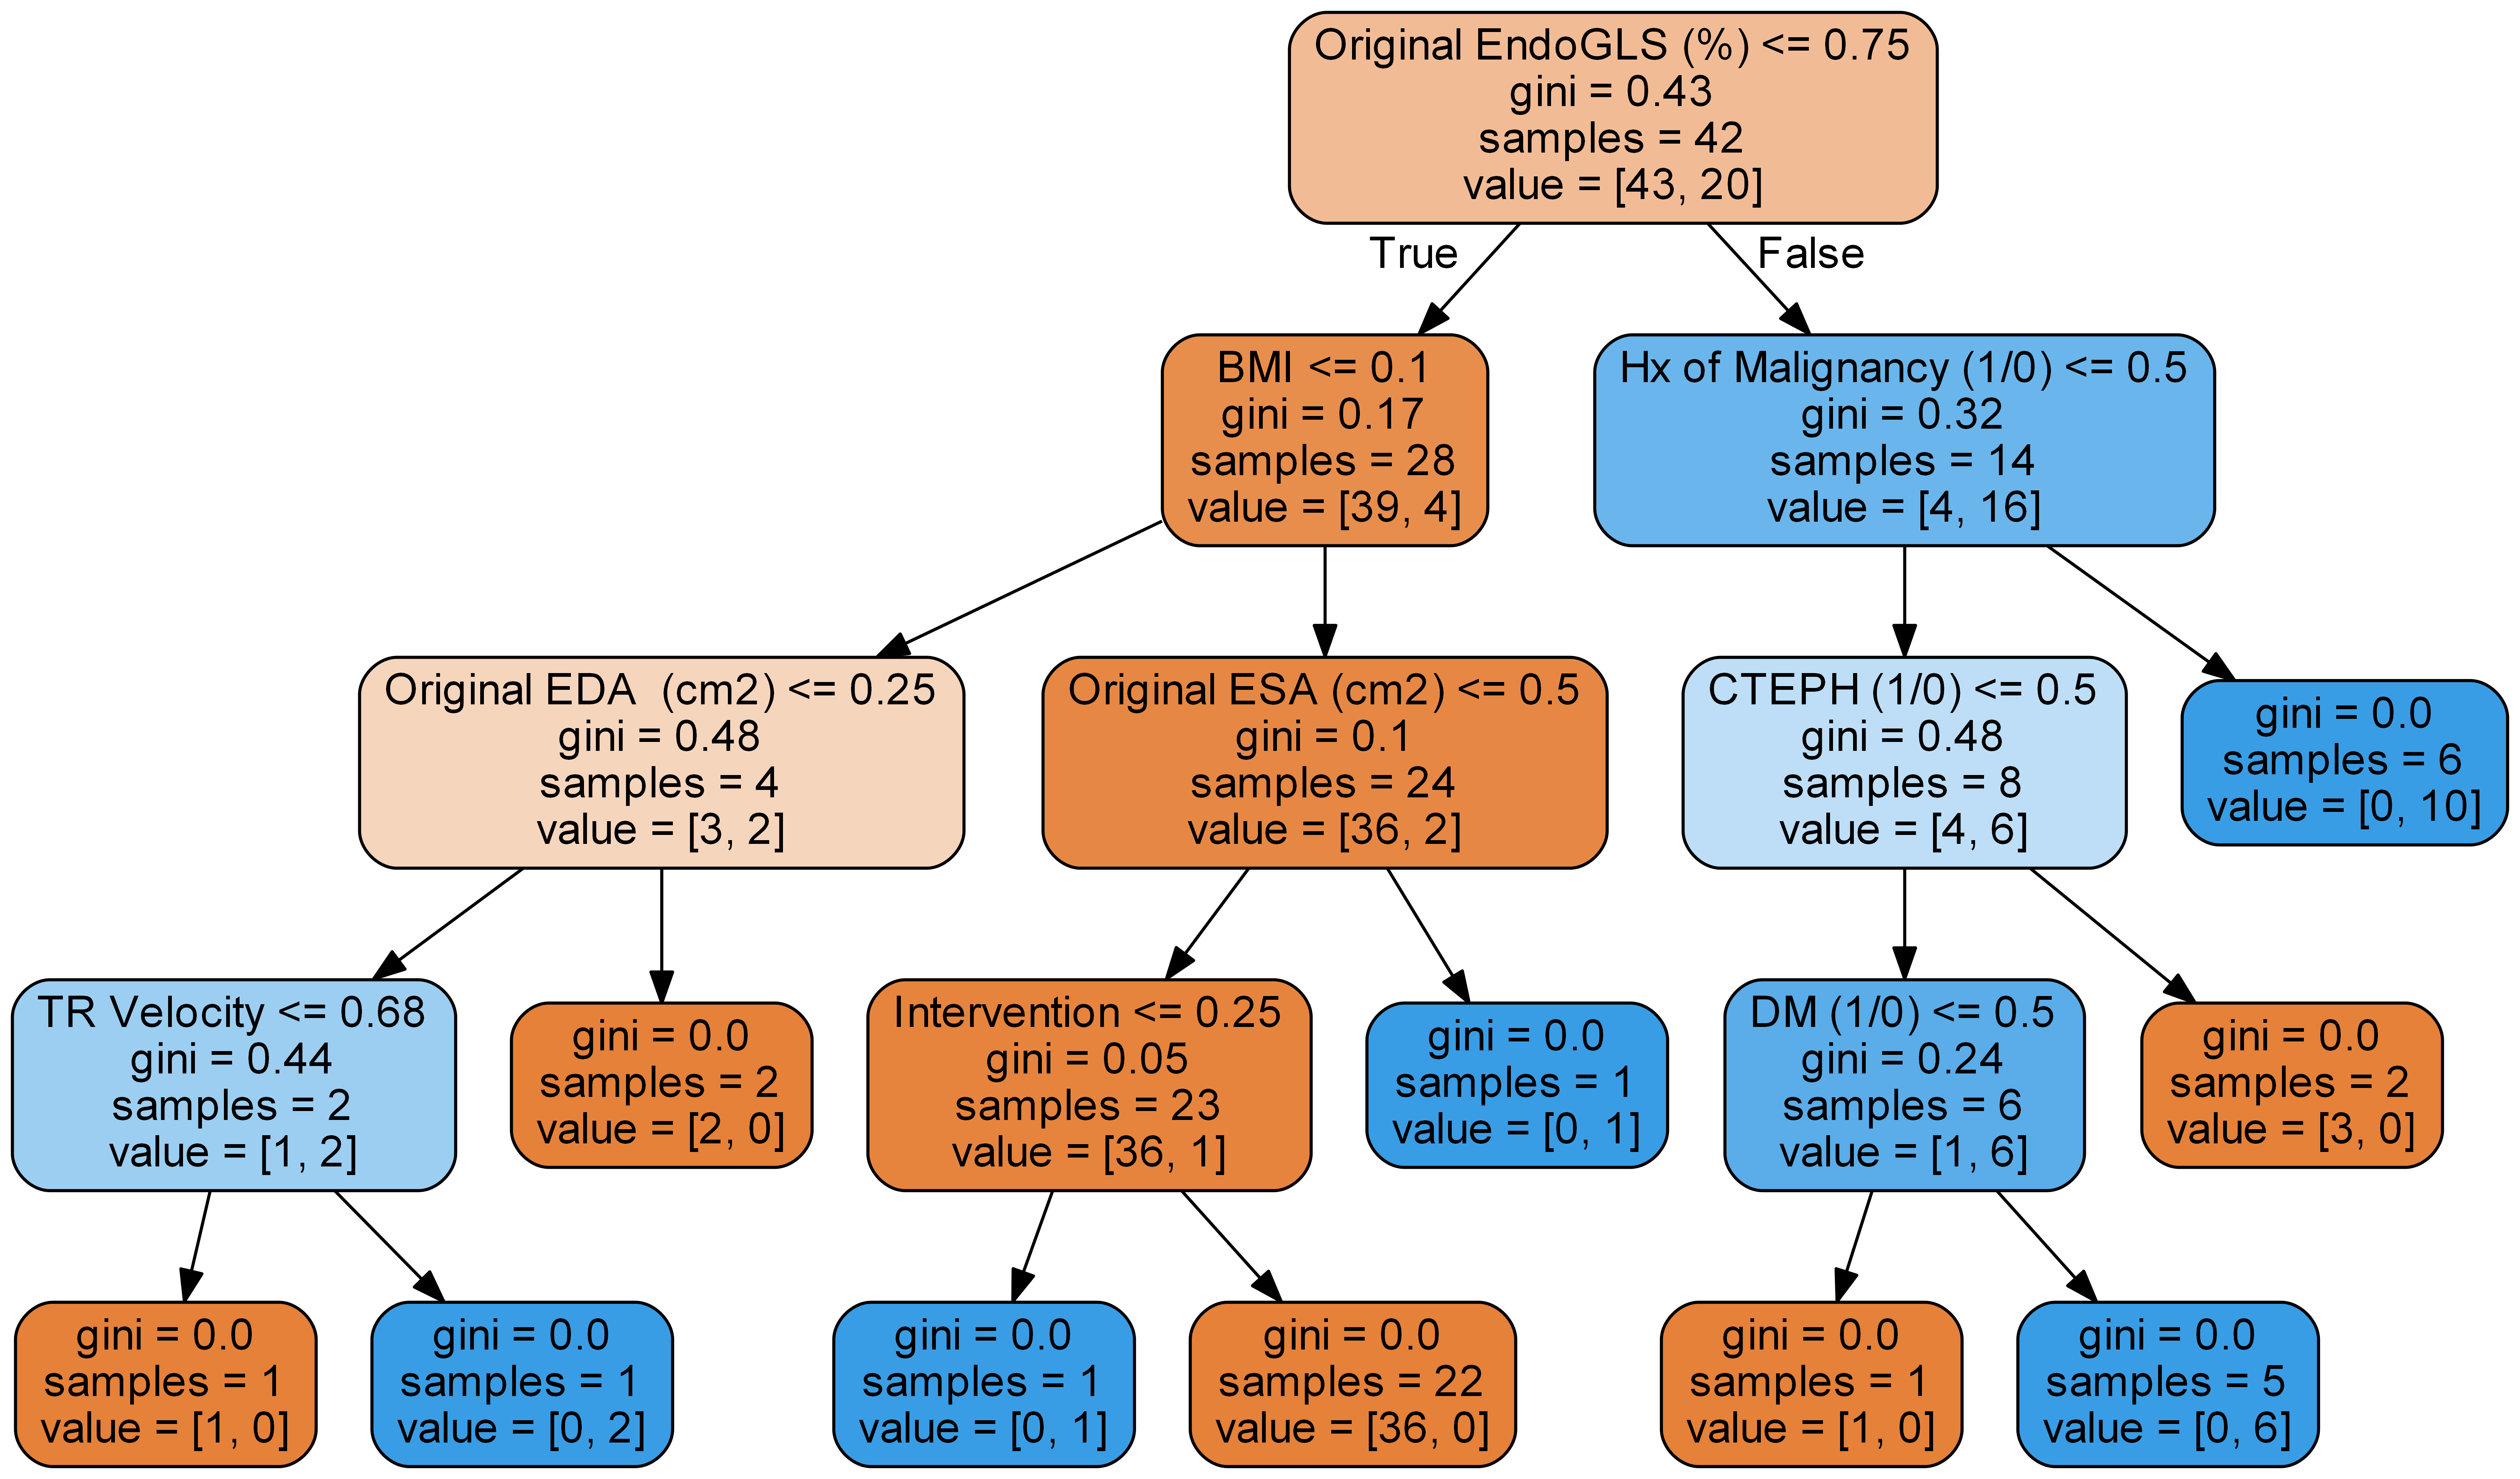

In [10]:
# Print sample tree from random forest

estimator = model.estimators_[10]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = col_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook

from IPython.display import Image
Image(filename = 'tree.png')

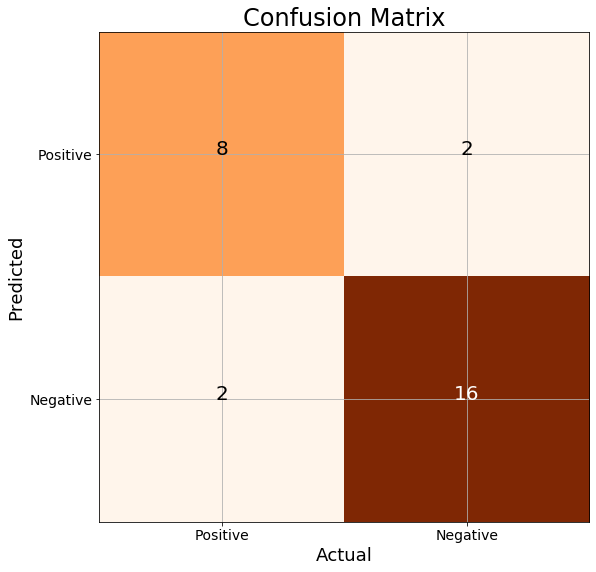

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):


    # Plot the confusion matrix
    plt.figure(figsize = (8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20, horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('Predicted', size = 18)
    plt.xlabel('Actual', size = 18)

classes = ['Positive', 'Negative']
# tn, fp, fn, tp = confusion_matrix(test_labels, y_preds).ravel()
# print("true negative: {}".format(tn))
# print("false positive: {}".format(fp))
# print("false negative: {}".format(fn))
# print("true positive: {}".format(tp))
cm = confusion_matrix(test_labels, y_preds)
cm = cm.transpose()
cm = np.rot90(cm, k=2, axes=(0, 1))
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix')

In [12]:
# Extract feature importances

fi = pd.DataFrame({'feature': list(col_names),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(10)

,feature,importance
11,Original EndoGLS (%),0.267111
10,Original FAC (%),0.107327
17,TR Velocity,0.102574
9,Original ESA (cm2),0.100961
8,Original EDA (cm2),0.066709
18,Intervention,0.062539
1,BMI,0.050375
13,RVSP,0.045169
7,Hx of Malignancy (1/0),0.044547
14,RV Size,0.033023


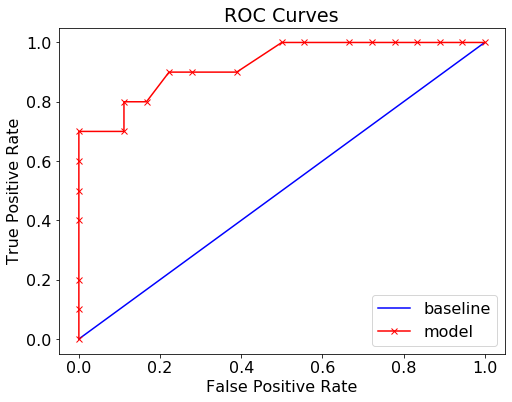

In [13]:
# Output of ROC curve
   
# Calculate false positive rates and true positive rates

probs = model.predict_proba(test)[:, 1]

base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
model_fpr, model_tpr, _ = roc_curve(test_labels, probs, drop_intermediate = False)


df_fpr = pd.DataFrame(model_fpr, columns = ['False Positive Rate'])
df_tpr = pd.DataFrame(model_tpr, columns = ['True Positive Rate'])

# Plot both curves

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', marker = 'x', label = 'model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()